In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
from hermes3.selectors import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [3]:
toload = [ 
    # dict(name="base", id="upst1ai-strumpack_Tnorm_x10_match_fluxlim", unnormalise = True), 
    # dict(name="new", id="upst5a-reimplement_AFN_from_upst1ah", unnormalise = True), 
    dict(name="base", id="upst7bx-clim_1.0_freeze", unnormalise = True), 
    dict(name="highmfp", id="upst7c-clim_1.0_maxmfp_1", unnormalise = True), 
    
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = False, verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case upst7bx-clim_1.0_freeze
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes
- Reading case upst7c-clim_1.0_maxmfp_1
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# I had the normalisation by metres off: i did it inside the .withDefault bracket instead of outside. This meant it wouldn't get normalised when you set a particular value.

# New

In [4]:
def grad_perp(ds, f):

    x = f.bout.ddx() - ds["g_12"] * f.bout.ddy() / (ds["J"] * ds["Bxy"])**2
    y = np.zeros_like(x)
    z = - ds["g_23"] * f.bout.ddy() / (ds["J"] * ds["Bxy"])**2
    
    if "z" in ds.coords:
        z = f.bout.ddz() + z

    
    return x,y,z
# Units of f divided by x, and x is in Wb=Tm^2
# x is in poloidal flux 
# ddy has no units cause y is angle
# ddx is units of f/Wb?
# z has no units cause z is angle
# DOT PRODUCT IS A CUSTOM OPERATOR WITH METRIC COEFFICIENTS!!

In [5]:
# name = "base"
# df = dfs[name]
# ds = cs[name].ds
# if "t" in ds.sizes: ds = ds.isel(t=-1)
# m = ds.metadata
# Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
# Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")
# pn_floor = 1e-8 * 1/100 * Pnorm

# Pnlim = softFloor(ds["Pd"], pn_floor);
# logPnlim = np.log(Pnlim)

# pf_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Nd"], logPnlim)
# ds["pf_calc"] = (["x", "theta"], pf_xlow.data)

dfs = {}

for name in cs:
    ds = cs[name].ds
    if "t" in ds.sizes: ds = ds.isel(t=-1)
    
    ds["Vd"] = ds["NVd"] / ds["Nd"] / (constants("mass_p") * 2)
    
    m = ds.metadata
    Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
    Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")
    pn_floor = 1e-8 * 1/100 * Pnorm

    Pnlim = softFloor(ds["Pd"], pn_floor);
    logPnlim = np.log(Pnlim)

    ds["grad_perp_logPnlim_x_calc"], _, _ = grad_perp(ds, logPnlim)
    
    kappa_n = 5/2 * ds["Dnnd"] * ds["Nd"]
    # eta_n = 2*constants("mass_p") * 2/5 * kappa_n
    eta_n = 2/5 * kappa_n
    
    pf_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Nd"], logPnlim)
    mf_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["NVd"], logPnlim)
    ef_adv_xlow, _ = Div_a_Grad_perp_fast(ds, ds["Dnnd"] * ds["Pd"], logPnlim)
    ef_cond_xlow, _ = Div_a_Grad_perp_fast(ds, kappa_n, ds["Td"]*constants("q_e"))
    
    # mf_visc_xlow, _ = Div_a_Grad_perp_fast(ds, 2 * eta_n, ds["Vd"])
    mf_visc_xlow, _ = Div_a_Grad_perp_fast(ds, eta_n, ds["Vd"])
    
    ef_adv_xlow *= 5/2
    ef_cond_xlow *= 3/2

    
    ds["pf_adv_calc"] = (["x", "theta"], pf_adv_xlow.data)
    ds["mf_adv_calc"] = (["x", "theta"], mf_adv_xlow.data)
    ds["ef_adv_calc"] = (["x", "theta"], ef_adv_xlow.data)
    ds["ef_cond_calc"] = (["x", "theta"], ef_cond_xlow.data)
    ds["mf_visc_calc"] = (["x", "theta"], mf_visc_xlow.data)
    
    if "fluxlimd_pf_perp" in ds:
        ds["pf_adv_calc_timeslim"] = ds["pf_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["mf_adv_calc_timeslim"] = ds["mf_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["ef_adv_calc_timeslim"] = ds["ef_adv_calc"] * ds["fluxlimd_pf_perp"]
        ds["ef_cond_calc_timeslim"] = ds["ef_cond_calc"] * ds["fluxlimd_ef_perp"]
        ds["mf_visc_calc_timeslim"] = ds["mf_visc_calc"] * ds["fluxlimd_mf_perp"]

    
    dfs[name] = get_1d_radial_data(ds, [
        # "pfd_adv_perp_xlow", "mfd_adv_perp_xlow", "efd_adv_perp_xlow", "efd_cond_perp_xlow", "mfd_visc_perp_xlow",
                                        "dx", "dy", "dz", "g22", "g_33", "g_12", "g_11", "J", "Bxy",
                                        "Nd", "Ne", "Pd", "Td", 
                                        "Rnn",
                                        # "Vd", 
                                        "Vd+",
                                        "Dnnd", 
                                        # "Dnnd_check", "Dmaxd",
                                        "Kdd+_cx", "Sd+_iz", "Kd_diff", "Kd_diff_mfp",
                                        # "Vd_perp_x", "Vd_perp_y", "Vd_perp_abs",
                                        "kappa_n_d",
                                        # "grad_perp_logPnlim_x_d",
                                        "grad_perp_logPnlim_x_calc", 
                                        # "fluxlimd_pf_perp", "fluxlimd_ef_perp", "fluxlimd_mf_perp",
                                        "pf_adv_calc", "mf_adv_calc", "ef_adv_calc", "ef_cond_calc", "mf_visc_calc",
                                        "pf_adv_calc_timeslim", "mf_adv_calc_timeslim", "ef_adv_calc_timeslim", "ef_cond_calc_timeslim", "mf_visc_calc_timeslim",
                                        ], "omp")

    df = dfs[name]
    Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
    Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

    df["dpol"] = df["dy"] * np.sqrt(df["g22"])
    df["dtor"] = df["dz"] * np.sqrt(df["g_33"])
    df["darad"] = df["dpol"] * df["dtor"]
    pn_floor = 1e-8 * 1/100 * Pnorm
    df["Pnlim"] = np.clip(df["Pd"], pn_floor, None)

    # df["pflux"] = df["pfd_adv_perp_xlow"] / df["darad"]
    df["logPnlim"] = np.log(df["Pnlim"])
    df["kappa_n"] = 5/2 * df["Dnnd"] * df["Nd"]
    dfs[name] = df

Parameter Rnn not found
Parameter Kd_diff not found
Parameter Kd_diff_mfp not found
Parameter kappa_n_d not found
Parameter pf_adv_calc_timeslim not found
Parameter mf_adv_calc_timeslim not found
Parameter ef_adv_calc_timeslim not found
Parameter ef_cond_calc_timeslim not found
Parameter mf_visc_calc_timeslim not found
Parameter Kd_diff not found
Parameter Kd_diff_mfp not found
Parameter kappa_n_d not found
Parameter pf_adv_calc_timeslim not found
Parameter mf_adv_calc_timeslim not found
Parameter ef_adv_calc_timeslim not found
Parameter ef_cond_calc_timeslim not found
Parameter mf_visc_calc_timeslim not found


### Dnn

In [6]:
cs.keys()

dict_keys(['base', 'highmfp'])

From options: maximum_mfp=1
From options: pressure_floor=1.60217662e-08
From options: density_floor=1000000000.0


/tmp/ipykernel_2507134/1533482116.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize = "x-small")


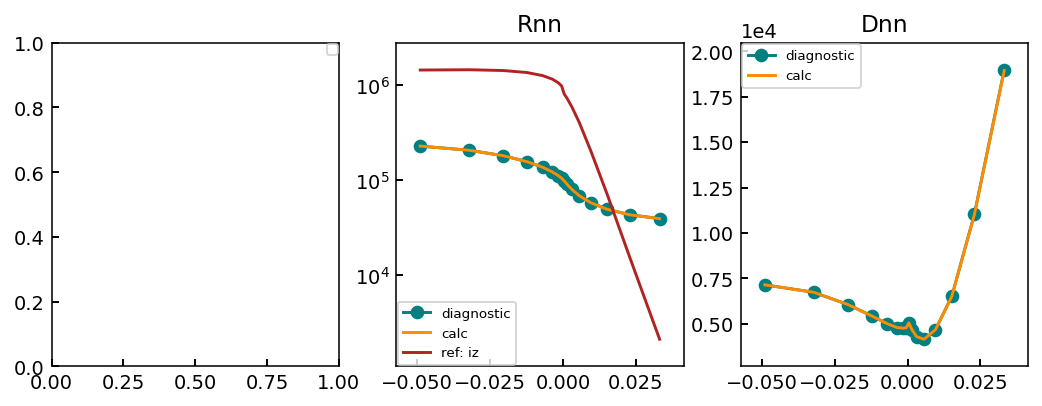

In [7]:
name = "highmfp"


df = dfs[name]
ds = cs[name].ds
if "t" in ds.sizes: ds = ds.isel(t=-1)
m = ds.metadata

Mi = 2 * constants("mass_p")
qe = constants("q_e")

maximum_mfp = ds.options["d"]["neutral_lmax"]
# maximum_mfp = 0.1

pressure_floor = ds.options["d"]["pn_floor"] * m["Nnorm"] * m["Tnorm"] * qe
density_floor = ds.options["d"]["nn_floor"] * m["Nnorm"]
temperature_floor = pressure_floor / density_floor / constants("q_e")

print(f"From options: maximum_mfp={maximum_mfp}")
print(f"From options: pressure_floor={pressure_floor}")
print(f"From options: density_floor={density_floor}")


particle_flux_limit_alpha = 0.2
df["Tnlim"] = softFloor(df["Td"], 0.1)
df["Nnlim"] = softFloor(df["Nd"], density_floor)

df["nu_calc_cx"] = df["Kdd+_cx"] 
df["nu_calc_iz"] = df["Sd+_iz"]/df["Nd"]
df["nu_calc_total"] = df["nu_calc_cx"] + df["nu_calc_iz"]  # Excludes mfp
df["nu_calc_mfp"] = np.sqrt(df["Tnlim"]*qe/Mi) / maximum_mfp


# df["grad_corr"] = df["g_12"] / (df["J"] * df["Bxy"])**2
# gradPerp = np.gradient(df["logPnlim"], df["dx"].cumsum() * df["grad_corr"])

df["Dnn_calc"] = (df["Tnlim"] * qe/Mi) / (df["nu_calc_total"] + df["nu_calc_mfp"])
# df["Dmax_calc"] = particle_flux_limit_alpha * np.sqrt(df["Tnlim"] * qe / Mi) / (df["grad_perp_logPnlim_x_calc"] + 1/df["nu_calc_total"])

fig, axes =plt.subplots(1,3, figsize = (3*3,3))

ax = axes[1]
ax.set_title("Rnn")
ax.plot(df["Srad"], df["Rnn"], "o-", label = "diagnostic")
ax.plot(df["Srad"], df["nu_calc_mfp"], label = "calc")
ax.plot(df["Srad"], df["nu_calc_iz"], label = "ref: iz")
ax.set_yscale("log")

ax = axes[2]
ax.set_title("Dnn")
ax.plot(df["Srad"], df["Dnnd"], "o-", label = "diagnostic")
ax.plot(df["Srad"], df["Dnn_calc"], label = "calc")

for ax in axes:
    ax.legend(fontsize = "x-small")